# Decision Trees

After linear regression, decision trees are probably the second most commonly known model used for regression. Decision trees are completely different from linear regression, in that they are not represented by an equation. They *are* still functions (mathematically-speaking), because a function is just a rule which assigns an output given an input. But the function looks completely different from what you're used to.

Below is an example of a decision tree being used to determine whether or not a passenger on the Titanic would survive:

![Titanic Decision Tree](https://drive.google.com/uc?id=1HFsNCP3879ncIIUb-2Ho7IveJiBHZeH8 "Titanic Decision Tree")

We refer to each "question" in the tree (e.g. "Is age > 9.5?") as a "leaf" or "node". A question you may be wondering is, how do we know what questions we should be asking at each leaf? Also, what should the cutoff be for each question? Why are we asking about age being greater than 9.5 instead of 10, 11, or something else altogether? The answer is, **decision trees automatically learn what questions to ask in order to generate the best possible predictions**. Let's jump in and start exploring.

## Imports

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Loading data

For this project we'll be working with the finishing times for male runners in the LA Marathon. We'll be training on model on 2016, and testing it on 2017. I scraped the data from [the official results site](https://www.trackshackresults.com/lamarathon/results/2016/).

In [ ]:
df = pd.read_csv('data/2016_la_marathon.csv')

In [ ]:
df.head()

div_place             name    bib  age  place  gender_place 5k_split  \
0          1    SAUL VISCARRA  40402   15    382           352    22:28   
1          2   FERNANDO GOMEZ  40504   15    560           504    22:37   
2          3  MARCOS GONZALEZ  40882   15   1042           881    24:08   
3          4     LUIS MORALES  42286   13   1294          1076    22:50   
4          5    PETER CASTANO  20099   15   1413          1166    26:13   

  10k_split 15k_split 20k_split 25k_split 30k_split 35k_split 40k_split  \
0     44:00   1:04:56   1:26:24   1:48:24   2:11:32   2:37:42   3:01:56   
1     45:17   1:07:50   1:31:42   1:55:46   2:19:58   2:44:35   3:09:32   
2     47:44   1:10:34   1:34:10   1:58:40   2:23:37   2:54:01   3:23:20   
3     46:21   1:11:07   1:34:42   1:58:49   2:24:17   2:54:27   3:26:22   
4     53:12   1:19:36   1:45:47   2:11:53   2:38:18   3:03:38   3:29:46   

  clock_time net_time  hometown  
0    3:22:41  3:11:51       NaN  
1    3:23:09  3:18:54       NaN  
2    3:43:35  3:31:59       NaN  
3    3:41:55  3:37:24       NaN  
4    3:45:48  3:39:31       NaN

## Data preparation

Let's start with our usual check of `NaN`/`None` values.

In [ ]:
for col in df.columns:
    missing_value_count = df[col].isna().sum()
    print(f'{col}: {missing_value_count} missing')

div_place: 0 missing
name: 0 missing
bib: 0 missing
age: 0 missing
place: 0 missing
gender_place: 0 missing
5k_split: 821 missing
10k_split: 158 missing
15k_split: 101 missing
20k_split: 91 missing
25k_split: 73 missing
30k_split: 140 missing
35k_split: 95 missing
40k_split: 161 missing
clock_time: 0 missing
net_time: 0 missing
hometown: 11499 missing


It looks like a number of them are missing. This could be from people dropping out of the race, never showing up, etc. Since we're trying to predict finishing time, let's drop any rows which having a missing split.

In [ ]:
split_columns = ['5k_split', '10k_split', '15k_split', '20k_split', '25k_split', '30k_split', '35k_split', '40k_split']

df = df.dropna(how='any', subset=split_columns)

We want to predict the runners placing based on their how fast they run, along with potentially some other information. Currently, their splits (times) at each 5 kilometers is written in the form `hours:minutes:seconds`. That's not really what we want, we need numbers to work with. So we'll start by converting those values to minutes. To do so we'll use the Pandas `.apply()` function, which takes in a function, and applies it to each row individually. 

Let's write our function to look for the ':' character, and then split at it. Note that depending on how fast/slow the runner was, there could be more than one colon in their time (for `hours:minutes:seconds` versus just `minutes:seconds`). So we'll need to check the length of our list and process each part individually. To convert seconds into minutes we'll divide by 60, and to convert hours into minutes we'll multiply by 60. Finally, since we're starting with a string, when we split it, we will again receive strings. Let's do a simple test case first to make sure we have the idea.

In [ ]:
speed_split = '23:45'.split(':')
print(f'The value {speed_split[0]} is a {type(speed_split[0])}')
print(f'The value {speed_split[1]} is a {type(speed_split[1])}')

The value 23 is a <class 'str'>
The value 45 is a <class 'str'>


This works, but if we're going to do math, we need integers, not strings. So we'll convert each to an integer as well.

In [ ]:
speed_split = '23:45'.split(':')
print(f'The value {int(speed_split[0])} is a {type(int(speed_split[0]))}')
print(f'The value {int(speed_split[1])} is a {type(int(speed_split[1]))}')

The value 23 is a <class 'int'>
The value 45 is a <class 'int'>


Let's now write our function to take in an arbitrary speed (written as a string), split it up, convert it to minutes, and return it.

In [ ]:
def split_to_minutes(speed):
    speed_split = speed.split(':')
    # If there's only one colon, so minutes:seconds
    if len(speed_split) == 2:
        minutes = int(speed_split[0]) + int(speed_split[1])/60
    # If there's two colon, so hours:minutes:seconds
    if len(speed_split) == 3:
        minutes = 60*int(speed_split[0]) + int(speed_split[1]) + int(speed_split[2])/60
    return minutes

Let's test it.

In [ ]:
split_to_minutes('10:35')

10.583333333333334

With that, we can now `apply` our function to our dataframe. It's good practice to not overwrite a column in a dataframe, because maybe you'll need it later. So we'll create a new column for each 5 kilometers, titled `5k_split_min`, `10k_split_min`, etc., as well as any other columns with times in them. We *could* go through and do this one at a time, but by using a `for` loop we can save ourselves time.

In [ ]:
# An error is coming...
time_columns = ['5k_split', '10k_split', '15k_split', '20k_split', '25k_split', '30k_split', '35k_split', '40k_split', 'clock_time', 'net_time']

for col in time_columns:
    df[f'{col}_min'] = df[col].apply(split_to_minutes)

ValueError: invalid literal for int() with base 10: '0-33'

Oh no! Reading the error, it looks like someone has a time of '0-33' which is causing issues when we try to convert it to an integer. So perhaps we should modify our function to first check for a valid value, and if it's not valid, to just fill in a `None`. Then we can drop rows with `None` afterward. To do so, we'll use the Python pattern `try`...`except`.... What this does is to `try` and do what you ask, but if an error occurs, rather than just crashing and throwing the error, it enters the `except` block. You can then make something else happen in there, like filling in a `None`.

In [ ]:
def split_to_minutes(speed):
    speed_split = speed.split(':')
    for value in speed_split:
        try:
            # Check if it can be converted to an integer. If it can't, this will fail and Python will proceed to the "except" part
            int(value)
        except Exception as e:
            return None
    # This part below is just the function we wrote above
    if len(speed_split) == 2:
        minutes = int(speed_split[0]) + int(speed_split[1])/60
    if len(speed_split) == 3:
        minutes = 60*int(speed_split[0]) + int(speed_split[1]) + int(speed_split[2])/60
    return minutes

In [ ]:
split_columns = ['5k_split', '10k_split', '15k_split', '20k_split', '25k_split', '30k_split', '35k_split', '40k_split']
time_columns = split_columns + ['clock_time', 'net_time']

for col in time_columns:
    df[f'{col}_min'] = df[col].apply(split_to_minutes)

In [ ]:
df.head()

div_place             name    bib  age  place  gender_place 5k_split  \
0          1    SAUL VISCARRA  40402   15    382           352    22:28   
1          2   FERNANDO GOMEZ  40504   15    560           504    22:37   
2          3  MARCOS GONZALEZ  40882   15   1042           881    24:08   
3          4     LUIS MORALES  42286   13   1294          1076    22:50   
4          5    PETER CASTANO  20099   15   1413          1166    26:13   

  10k_split 15k_split 20k_split  ... 5k_split_min 10k_split_min 15k_split_min  \
0     44:00   1:04:56   1:26:24  ...    22.466667     44.000000     64.933333   
1     45:17   1:07:50   1:31:42  ...    22.616667     45.283333     67.833333   
2     47:44   1:10:34   1:34:10  ...    24.133333     47.733333     70.566667   
3     46:21   1:11:07   1:34:42  ...    22.833333     46.350000     71.116667   
4     53:12   1:19:36   1:45:47  ...    26.216667     53.200000     79.600000   

  20k_split_min 25k_split_min 30k_split_min  35k_split_min  40k_split_min  \
0     86.400000    108.400000    131.533333     157.700000     181.933333   
1     91.700000    115.766667    139.966667     164.583333     189.533333   
2     94.166667    118.666667    143.616667     174.016667     203.333333   
3     94.700000    118.816667    144.283333     174.450000     206.366667   
4    105.783333    131.883333    158.300000     183.633333     209.766667   

   clock_time_min  net_time_min  
0      202.683333    191.850000  
1      203.150000    198.900000  
2      223.583333    211.983333  
3      221.916667    217.400000  
4      225.800000    219.516667  

[5 rows x 27 columns]

Looking good! Let's see where `None`'s occurred as a result of bad values.

In [ ]:
for col in df.columns:
    missing_value_count = df[col].isna().sum()
    print(f'{col} - {missing_value_count} missing')

div_place - 0 missing
name - 0 missing
bib - 0 missing
age - 0 missing
place - 0 missing
gender_place - 0 missing
5k_split - 0 missing
10k_split - 0 missing
15k_split - 0 missing
20k_split - 0 missing
25k_split - 0 missing
30k_split - 0 missing
35k_split - 0 missing
40k_split - 0 missing
clock_time - 0 missing
net_time - 0 missing
hometown - 10375 missing
5k_split_min - 4 missing
10k_split_min - 0 missing
15k_split_min - 0 missing
20k_split_min - 0 missing
25k_split_min - 0 missing
30k_split_min - 0 missing
35k_split_min - 0 missing
40k_split_min - 0 missing
clock_time_min - 0 missing
net_time_min - 0 missing


Looks like just a couple in `5k_split_min`. Let's drop and we should be good to go!

In [ ]:
df = df.dropna(how='any', subset=['5k_split_min'])

In [ ]:
df.shape

(10371, 27)

So we still have over 10,000 runners left to work with, that should be plenty for our purposes. With our data prepped, let's start modeling.

## Decision trees <a id="intro_dt"></a>
Let's just jump right in and use `sklearn`'s implementation of `DecisionTree`. We want to predict their placing, so this is a *regression* problem, because we are predicting a continuous value. While placing is not *really* continuous (no one could get 4.3 place), there are so many possible values that it would be ridiculous to have a different category for each place. Therefore, it makes more sense to think of it as being continuous than as being categorical. Decision trees can be used for both regression and classification. They are more commonly used for classification, but we'll start by using it for regression. To do so we will be using `DecisionTreeRegressor` from sklearn. Training it and making predictions with it should look exactly like how we did for linear regression. Let's use all of our splits to predict their finishing place. We said we'll test on 2017, but let's still split 2016 into two sets in order to have something to tune our model with. Since 2017 is our true "test" data, it doesn't make sense to say we're splitting 2016 into train and "test" data. Thus subsetting the data this way is referred to as creating a "validation set". A **validation set** is used to tweak your model until you're ready to actually test it. It's best practice to keep your test data as true test data, and not "show it" to your model before your model is ready.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Our new split columns are named the same as the old split column, but with "_min" appended. So let's create a list of those.
split_columns_min = [f'{x}_min' for x in split_columns]
split_cols_and_age = split_columns_min + ['age']

X_train, X_valid, y_train, y_valid = train_test_split(df[split_cols_and_age], df['gender_place'], train_size=0.7)

In [ ]:
X_train.head()

5k_split_min  10k_split_min  15k_split_min  20k_split_min  \
2111      36.450000      68.966667      98.183333     129.983333   
8256      27.916667      55.066667      82.016667     108.916667   
4209      29.833333      60.433333      90.866667     123.050000   
5336      22.366667      44.883333      67.383333      89.833333   
11394     29.583333      60.600000      90.250000     120.016667   

       25k_split_min  30k_split_min  35k_split_min  40k_split_min  age  
2111      163.216667     203.983333     246.666667     286.816667   22  
8256      139.033333     166.833333     201.250000     232.483333   46  
4209      154.800000     187.750000     222.083333     255.266667   30  
5336      112.233333     135.733333     166.750000     200.400000   38  
11394     150.650000     181.816667     213.216667     244.083333   72

Using a decision tree in sklearn is exactly like how you've used all other models in sklearn! From the perspective of someone learning machine learning, one of the best features about sklearn is how consistent it is. Pretty much every model follows the same pattern:

1. Instantiate the model (meaning something like `lr = LinearRegression()` or `clf = LogisticRegression()`.
2. Fit the model using `.fit()`
3. Use the model to make predictions using `.predict()`
4. (Optional) Get the score of the model (usually R^2 for regression and accuracy for classification) using `.score()`

Let's follow this same pattern here.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dt_reg = DecisionTreeRegressor()

In [ ]:
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
preds = dt_reg.predict(X_valid)

for i in range(10):
    print(f'Predicted: {preds[i]}, Actual: {y_valid.iloc[i]}, Diff = {preds[i]-y_valid.iloc[i]} ({100*abs(preds[i]-y_valid.iloc[i])/y_valid.iloc[i]:.2f}%)')

Predicted: 2506.0, Actual: 2545, Diff = -39.0 (1.53%)
Predicted: 800.0, Actual: 847, Diff = -47.0 (5.55%)
Predicted: 10298.0, Actual: 10197, Diff = 101.0 (0.99%)
Predicted: 8833.0, Actual: 8577, Diff = 256.0 (2.98%)
Predicted: 10989.0, Actual: 10828, Diff = 161.0 (1.49%)
Predicted: 1959.0, Actual: 1890, Diff = 69.0 (3.65%)
Predicted: 10721.0, Actual: 10694, Diff = 27.0 (0.25%)
Predicted: 1368.0, Actual: 1328, Diff = 40.0 (3.01%)
Predicted: 2193.0, Actual: 2157, Diff = 36.0 (1.67%)
Predicted: 1674.0, Actual: 1724, Diff = -50.0 (2.90%)


So most of these predictions are within a handful of percent (50-ish places) of being correct, that's impressive! For comparison, let's also build a linear regressor with this same data and compare the MSE from both.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
preds_lr = lr.predict(X_valid)

for i in range(10):
    print(f'Predicted: {preds_lr[i]}, Actual: {y_valid.iloc[i]}, Diff = {preds_lr[i]-y_valid.iloc[i]} ({100*abs(preds_lr[i]-y_valid.iloc[i])/y_valid.iloc[i]:.2f}%)')

Predicted: 2881.4505952084746, Actual: 2545, Diff = 336.4505952084746 (13.22%)
Predicted: 1019.8154901168928, Actual: 847, Diff = 172.81549011689276 (20.40%)
Predicted: 9987.114569245616, Actual: 10197, Diff = -209.8854307543843 (2.06%)
Predicted: 8196.702056815542, Actual: 8577, Diff = -380.29794318445784 (4.43%)
Predicted: 11653.02324126436, Actual: 10828, Diff = 825.02324126436 (7.62%)
Predicted: 2274.0219966673267, Actual: 1890, Diff = 384.0219966673267 (20.32%)
Predicted: 11318.176668353688, Actual: 10694, Diff = 624.176668353688 (5.84%)
Predicted: 1798.1529686199756, Actual: 1328, Diff = 470.1529686199756 (35.40%)
Predicted: 2442.903099096622, Actual: 2157, Diff = 285.9030990966221 (13.25%)
Predicted: 2144.7100749666715, Actual: 1724, Diff = 420.7100749666715 (24.40%)


The tree model looks to have done much better! Let's compare R^2 and MSE to be sure.

In [ ]:
print(f'Decision tree R^2 = {dt_reg.score(X_valid, y_valid)**2}')
print(f'Linear regression R^2 = {lr.score(X_valid, y_valid)**2}')

Decision tree R^2 = 0.9972689036020543
Linear regression R^2 = 0.9579743493585986


In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
print(f'Linear regresion MSE = {mse(preds_lr, y_valid)}')
print(f'Decision Tree MSE = {mse(preds, y_valid)}')

Linear regresion MSE = 231799.09438088024
Decision Tree MSE = 14914.017030848328


That's a huge difference!

We said that a decision tree makes decisions by learning to split each leaf at a particular value. So what decisions did our tree learn to make? To answer that we can *visualize* our tree. `sklearn` has a built-in function called `plot_tree`. **Warning: Plotting this will take a while...**

In [ ]:
from sklearn.tree import plot_tree

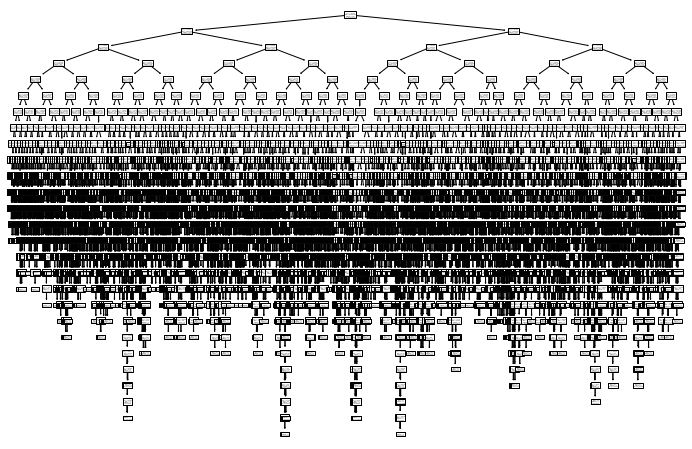

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(dt);

## Overfitting and hyperparameters <a id="overfitting_hyperparams"></a>

Woah, what happened there!? It looks like our tree is incredibly complex, with many, many different pathways and conditions. That's not really what we want, because it's likely the case that our model is *overfitting*. By **overfitting** we mean developing an overly complex model which does not generalize well to other scenarios. So it's likely that the super-specific rules it learned *will not* apply well to 2017, nor any other year.

When building a tree there are various hyperparameters that are used to control how the tree is grown. By **hyperparameters** we mean the values in a model that must be chosen by the user (as opposed to being *learned* from the data). The most common hyperparameters for decision trees are the following:
- `max_depth`: Controls how many levels the tree can have (so `max_depth=1` means only one "question" can be asked to split the tree).
- `min_samples_split`: Controls how many samples need to be seen which satisfy a rule before a new rule can be created. So if only two runners have a 5k split faster than 20 minutes (say), then by setting `min_samples_split=3` (or anything bigger than 2), no new rules would be created for these runners. This helps avoid creating ultra-specific nodes which may not generalize well.
- `max_features`: How many columns can be considered. Again, this controls creating super-specific rules that require many, many columns to satisfy.

Let's look at the depth and number of leaves of the tree we just built.

In [ ]:
print(f'Depth = {dt.get_depth()}')
print(f'# of leaves = {dt.get_n_leaves()}')

Depth = 26
# of leaves = 7259


So our decision tree had thousands of different "rules" (i.e. leaves). Since we only had a little over 10k runners, this means most runners had their own individual rule! This is a problem, because we want to build a model that would work *in general*, not just on the data we trained it on. However, our tree instead learned a specific rule for every 1 or 2 runners. This could be something like "if their 5k time was less than 48 minutes and their 10k time was greater than 60 minutes and their 15k was less than... then predict 5920'th place". This is what we mean by "overfitting". 

The way to avoid overfitting is to restrict our tree by picking hyperparameters that do not allow ultra-specific rules to be learned. Let's try building our tree again, but starting with some very mild hyperparameter choices to avoid this phenomenon of having an overly-complex tree. To do so, you simply need to supply these hyperparameters to the decision tree when you instantiate it (step 1).

In [ ]:
dt_simple = DecisionTreeRegressor(max_depth=3, min_samples_split=5)

dt_simple.fit(X_train, y_train)

preds_simple = dt_simple.predict(X_valid)

Let's plot this decision tree as well to see what it's like.

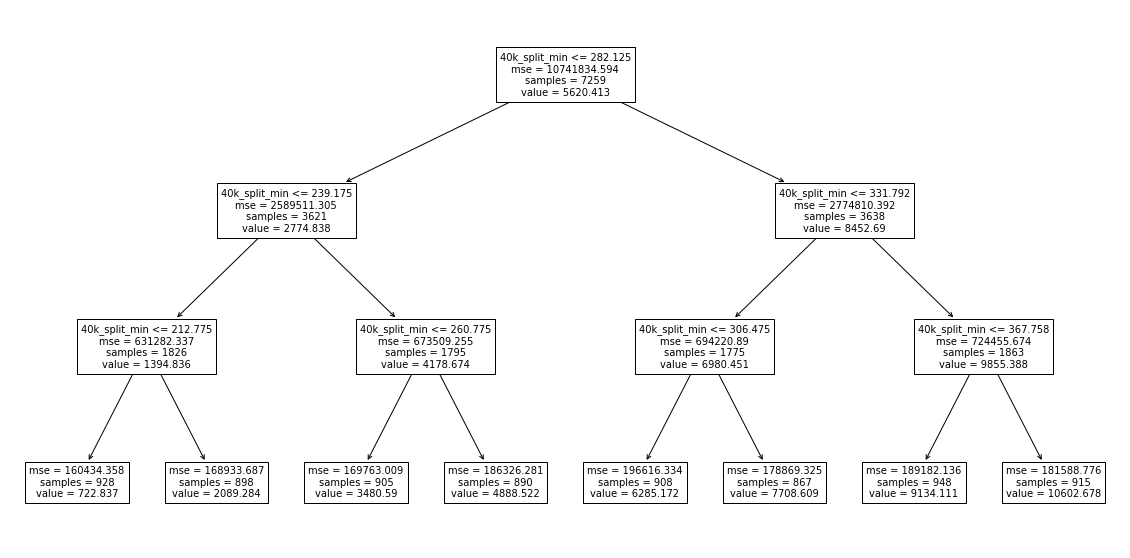

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(dt_simple, feature_names=split_columns_min);

So we can see that it begins by looking at the `40k_split_min` time, splits it at 282.125 minutes, and then makes other decisions based on that. This seems like a more reasonable way to design a tree.

We'd like to evaluate how well our model did. We've been doing that by putting some `print` statements inside a `for` loop, and also computing the MSE. Rather than continuing to copy-and-paste that code, let's create a function which does it for us.

In [ ]:
def summarize_model(preds, actual, num_examples=10):
    if isinstance(actual, pd.Series):
        actual = actual.values
        
    for i in range(num_examples):
        print(f'Predicted: {preds[i]:.2f}, Actual: {actual[i]:.2f}, Diff = {preds[i]-actual[i]:.2f} ({100*abs(preds[i]-actual[i])/actual[i]:.2f}%)')
        
    print()
    print(f'MSE: {mse(preds, actual)}')

In [ ]:
summarize_model(preds_simple, y_valid)

Predicted: 2089.28, Actual: 2545.00, Diff = -455.72 (17.91%)
Predicted: 722.84, Actual: 847.00, Diff = -124.16 (14.66%)
Predicted: 10602.68, Actual: 10197.00, Diff = 405.68 (3.98%)
Predicted: 9134.11, Actual: 8577.00, Diff = 557.11 (6.50%)
Predicted: 10602.68, Actual: 10828.00, Diff = -225.32 (2.08%)
Predicted: 2089.28, Actual: 1890.00, Diff = 199.28 (10.54%)
Predicted: 10602.68, Actual: 10694.00, Diff = -91.32 (0.85%)
Predicted: 722.84, Actual: 1328.00, Diff = -605.16 (45.57%)
Predicted: 2089.28, Actual: 2157.00, Diff = -67.72 (3.14%)
Predicted: 2089.28, Actual: 1724.00, Diff = 365.28 (21.19%)

MSE: 181762.05746029768


Not great, but we also drastically reduced the complexity of our decision tree, so that's to be expected. Also, notice that with only a very mild tree structure, our MSE of 182,162 is still lower than the MSE from linear regression of 220,525. 

Let's also plot the predictions made by the tree against the actual, correct values. On both the x- and y-axis we'll put the place the person got. This might seem weird, as normally the x-axis is what we feed into our model. But since we're feeding so many variables into our model, there's no single one to put on the x-axis. By putting the placing on both the x- and y-axis, a perfect prediction will be a diagonal line. However, our model is not perfect, so any deviation from that will let us see what's going on.

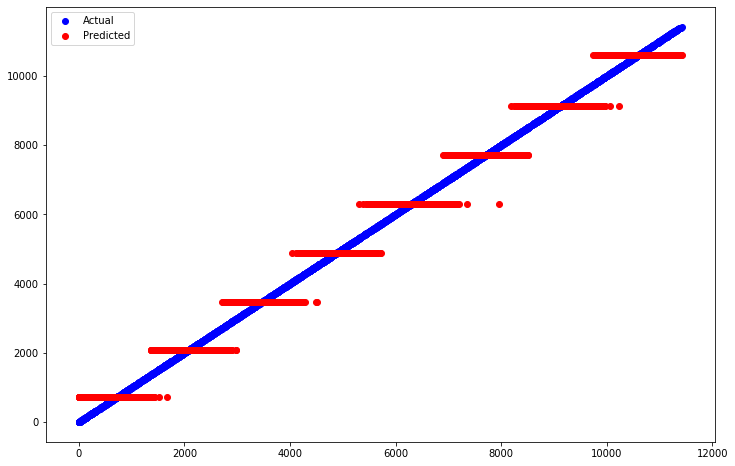

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(x=y_valid, y=y_valid, color='blue', label='Actual')
plt.scatter(x=y_valid, y=preds_simple, color='red', label='Predicted')
plt.legend();

So it looks like our tree is roughly learning a step-function. In fact, if you look above at the tree diagram, you'll see that each leaf on the bottom row tells you exactly what value it will predict for the placing for every runner who satisfied the necessary conditions to end up in that leaf. For example, to get to the first leaf on the left (starting at the top of the tree), a runner must have:
1. Had a 40k split of less than 282 minutes
2. Had a 40k split of less than 239 minutes
3. Had a 40k split less than 212 minutes
they would be assigned a finishing place of 722. Apparently there were 928 such runners (samples).
**WARNING: Your numbers may vary, as decision trees involve randomness, and each run will produce new results unless `random_state` is specified when building the tree.**

So wait a minute, *every leaf in the tree is just looking at the 40k split!* Why is that? Probably because that's the last split just 2 kilometers before the finishing line. So obviously the top finishers would be the fastest to that point! This is an example of building a model without really thinking about your data. If you're not careful you can easily get results which *seem* good, but upon closer inspection they are highly flawed. 

To build a more realistic and useful model, let's restrict ourselves to just the earlier splits to have a less-obvious problem. Let's take the first three splits (5k, 10k and 15k), along with their age. Again, let's first apply linear regression as a baseline. If our more complicated tree model can't beat a simple line, then we're doing something wrong.

In [ ]:
# Grab just these columns in the training and validation sets
# Note that the y doesn't change, because y is just their place, nothing to do with their times
splits_5_10_15_age_cols = ['5k_split_min', '10k_split_min', '15k_split_min', 'age']

X_train_splits_5_10_15_age = X_train[splits_5_10_15_age_cols]
X_valid_splits_5_10_15_age = X_valid[splits_5_10_15_age_cols]

In [ ]:
# Fit a linear regression model
lr_splits_5_10_15_age = LinearRegression()
lr_splits_5_10_15_age.fit(X_train_splits_5_10_15_age, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Fit a decision tree
dt_splits_5_10_15_age = DecisionTreeRegressor(max_depth=3, min_samples_split=5)
dt_splits_5_10_15_age.fit(X_train_splits_5_10_15_age, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
# Make predictions on the validation set with both the decision tree and the linear regression model
lr_splits_5_10_15_age_preds = lr_splits_5_10_15_age.predict(X_valid_splits_5_10_15_age)
dt_splits_5_10_15_age_preds = dt_splits_5_10_15_age.predict(X_valid_splits_5_10_15_age)

In [ ]:
# Results for linear regression
print('Linear model:')
print('='*20)
summarize_model(lr_splits_5_10_15_age_preds, y_valid)

Linear model:
Predicted: 2594.78, Actual: 2545.00, Diff = 49.78 (1.96%)
Predicted: 1791.78, Actual: 847.00, Diff = 944.78 (111.54%)
Predicted: 10640.01, Actual: 10197.00, Diff = 443.01 (4.34%)
Predicted: 8094.84, Actual: 8577.00, Diff = -482.16 (5.62%)
Predicted: 6810.22, Actual: 10828.00, Diff = -4017.78 (37.11%)
Predicted: 3196.10, Actual: 1890.00, Diff = 1306.10 (69.11%)
Predicted: 10615.06, Actual: 10694.00, Diff = -78.94 (0.74%)
Predicted: 2054.87, Actual: 1328.00, Diff = 726.87 (54.73%)
Predicted: 2295.13, Actual: 2157.00, Diff = 138.13 (6.40%)
Predicted: 2694.68, Actual: 1724.00, Diff = 970.68 (56.30%)

MSE: 1674606.3773056634


In [ ]:
# Results for the decision tree model
print('Decision tree model:')
print('='*20)
summarize_model(dt_splits_5_10_15_age_preds, y_valid)

Decision tree model:
Predicted: 2168.25, Actual: 2545.00, Diff = -376.75 (14.80%)
Predicted: 779.43, Actual: 847.00, Diff = -67.57 (7.98%)
Predicted: 8884.37, Actual: 10197.00, Diff = -1312.63 (12.87%)
Predicted: 7413.37, Actual: 8577.00, Diff = -1163.63 (13.57%)
Predicted: 7413.37, Actual: 10828.00, Diff = -3414.63 (31.54%)
Predicted: 2168.25, Actual: 1890.00, Diff = 278.25 (14.72%)
Predicted: 10278.75, Actual: 10694.00, Diff = -415.25 (3.88%)
Predicted: 2168.25, Actual: 1328.00, Diff = 840.25 (63.27%)
Predicted: 2168.25, Actual: 2157.00, Diff = 11.25 (0.52%)
Predicted: 2168.25, Actual: 1724.00, Diff = 444.25 (25.77%)

MSE: 1648919.7445526074


So the decision tree actually did slightly *worse* this time. Let's plot the predictions of both models against the actual values to get a feel for what's going on.

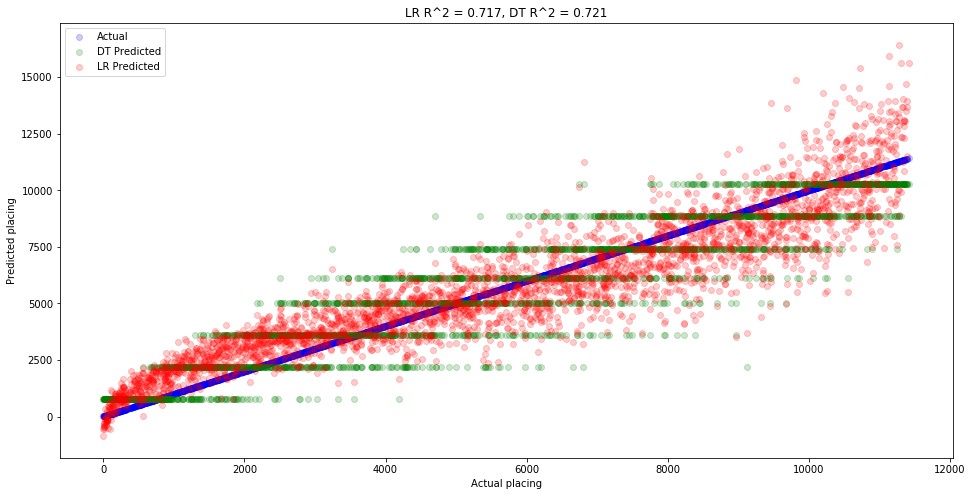

In [ ]:
plt.figure(figsize=(16,8))
plt.scatter(x=y_valid, y=y_valid, color='blue', label='Actual', alpha=0.2)
plt.scatter(x=y_valid, y=dt_splits_5_10_15_age_preds, color='green', label='DT Predicted', alpha=0.2)
plt.scatter(x=y_valid, y=lr_splits_5_10_15_age_preds, color='red', label='LR Predicted', alpha=0.2)

plt.xlabel('Actual placing')
plt.ylabel('Predicted placing')

lr_r2 = lr_splits_5_10_15_age.score(X_valid_splits_5_10_15_age, y_valid)**2
dt_r2 = dt_splits_5_10_15_age.score(X_valid_splits_5_10_15_age, y_valid)**2

plt.title(f'LR R^2 = {lr_r2:.3f}, DT R^2 = {dt_r2:.3f}')

plt.legend();

So again we see that the decision tree (green) is approximating a step function. You can see these values by going to the diagram we printed of our decision tree and looking at the leaves on the bottom row. Each one will say `value=...`, which is the value that gets assigned to that entire leaf. This is why decision trees are more often used for classification then regression. That's because regression typically involves continuous values, whereas decision trees produce decidedly non-continuous step functions. Having said that, decision trees are extremely powerful and should not be overlooked for any type of problem. 

Let's build one last decision tree, this time with a medium-level of depth and complexity. The point is to see how complex our tree needs to be before it outpeforms linear regression.

Linear model:
Predicted: 2594.78, Actual: 2545.00, Diff = 49.78 (1.96%)
Predicted: 1791.78, Actual: 847.00, Diff = 944.78 (111.54%)
Predicted: 10640.01, Actual: 10197.00, Diff = 443.01 (4.34%)
Predicted: 8094.84, Actual: 8577.00, Diff = -482.16 (5.62%)
Predicted: 6810.22, Actual: 10828.00, Diff = -4017.78 (37.11%)
Predicted: 3196.10, Actual: 1890.00, Diff = 1306.10 (69.11%)
Predicted: 10615.06, Actual: 10694.00, Diff = -78.94 (0.74%)
Predicted: 2054.87, Actual: 1328.00, Diff = 726.87 (54.73%)
Predicted: 2295.13, Actual: 2157.00, Diff = 138.13 (6.40%)
Predicted: 2694.68, Actual: 1724.00, Diff = 970.68 (56.30%)

MSE: 1674606.3773056634
Decision tree model:
Predicted: 1723.91, Actual: 2545.00, Diff = -821.09 (32.26%)
Predicted: 1182.63, Actual: 847.00, Diff = 335.63 (39.63%)
Predicted: 9469.34, Actual: 10197.00, Diff = -727.66 (7.14%)
Predicted: 7719.15, Actual: 8577.00, Diff = -857.85 (10.00%)
Predicted: 7719.15, Actual: 10828.00, Diff = -3108.85 (28.71%)
Predicted: 2252.04, Actual: 1890

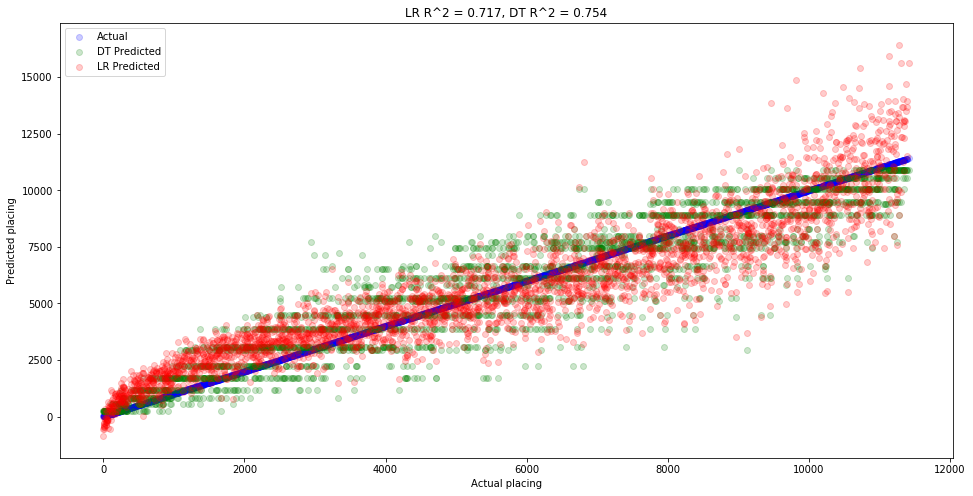

In [ ]:
# Create our tree
dt_splits_5_10_15_age2 = DecisionTreeRegressor(max_depth=5, min_samples_split=5)

# Train our tree
dt_splits_5_10_15_age2.fit(X_train_splits_5_10_15_age, y_train)

# Make predictions with our tree
dt_splits_5_10_15_age_preds2 = dt_splits_5_10_15_age2.predict(X_valid_splits_5_10_15_age)

# Compare predictions to linear regression
print('Linear model:')
print('='*20)
summarize_model(lr_splits_5_10_15_age_preds, y_valid)

print('Decision tree model:')
print('='*20)
summarize_model(dt_splits_5_10_15_age_preds2, y_valid)

# R^2
lr_r2 = lr_splits_5_10_15_age.score(X_valid_splits_5_10_15_age, y_valid)**2 # Same as above
dt_r2 = dt_splits_5_10_15_age2.score(X_valid_splits_5_10_15_age, y_valid)**2

# Plot the predictions
plt.figure(figsize=(16,8))
plt.scatter(x=y_valid, y=y_valid, color='blue', label='Actual', alpha=0.2)
plt.scatter(x=y_valid, y=dt_splits_5_10_15_age_preds2, color='green', label='DT Predicted', alpha=0.2)
plt.scatter(x=y_valid, y=lr_splits_5_10_15_age_preds, color='red', label='LR Predicted', alpha=0.2)

plt.xlabel('Actual placing')
plt.ylabel('Predicted placing')

plt.title(f'LR R^2 = {lr_r2:.3f}, DT R^2 = {dt_r2:.3f}')

plt.legend();

We've learned a valuable lesson in this notebook, which is that **just because a model gives better results, doesn't mean it's a better model.** We saw this with the decision tree, where it gave great predictions, but the tree itself was so complicated that it seemed unrealistic. Does it really make sense to have a model which requires most individuals to have their own custom rule. This leads to overfitting, which means models that don't generalize well. In the future, we'll look at our data more closely before just blindly picking a model to apply.

## The mathematics of decision trees <a id="math_dt"></a>

While we've now discussed *what* a decision tree is, there is still the question of *how* a decision tree is made. How is it that sklearn decides which column to look at first, and what the cutoff should be? Let's go back to the Titanic data to understand this.

In [ ]:
df = pd.read_csv(drive_dir + 'data/titanic.csv')

In [ ]:
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

Let's build a decision tree classifier to predict the survival. We'll then examine the tree and learn step-by-step how it was created. Let's start by preparing our data, including dropping missing values nad label encoding any `object` columns so that all values are numbers.

In [ ]:
# Drop any rows with missing values
df = df.dropna(how='any')

# Columns we'll actually use (things like "Name" are probably useless)
X_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
y_col = 'Survived'

df[X_cols].dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [ ]:
object_cols = ['Sex', 'Embarked']
# Save the label encoders here so that we can use them later if we want to go back to the original text
label_encoders = {}

for c in object_cols:
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])
    label_encoders[c] = le

In [ ]:
# Split the data into training and testing data
train_df, test_df = train_test_split(df)

X_train = train_df[X_cols]
y_train = train_df[y_col]

X_test = test_df[X_cols]
y_test = test_df[y_col]

Now we can build our classification tree.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_clf = DecisionTreeClassifier(max_depth=3, min_samples_split=5)

In [ ]:
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

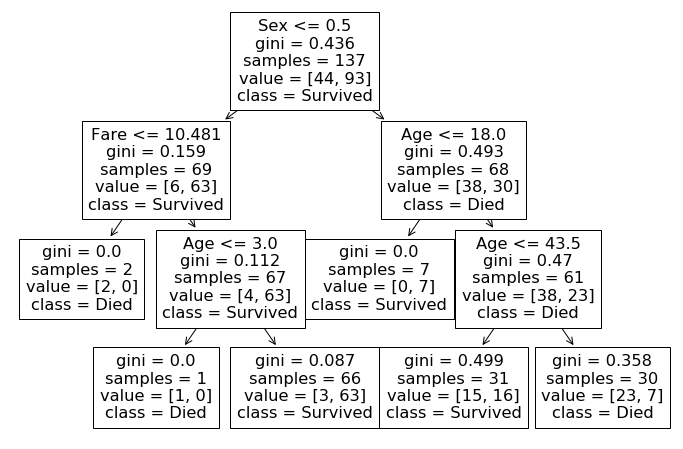

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(dt_clf, feature_names=X_train.columns, class_names=['Died', 'Survived']);

A decision tree makes its decision by trying to find which feature is the most important at each step. Let's think about how we could do this. Suppose that all the passengers on the Titanic were males (obviously this wasn't the case, but just bear with me). Then checking whether or not someone was a male would be useless, as it wouldn't tell us anything. Similarly, if all but just, say, five were males, then that too is not useful. Even if it ended up all females survived, then we've only concluded something about five passengers. Therefore, our first task is to choose a feature that has an even balance of samples. If your feature has more than one possible value (like how `PClass` can be 1, 2, or 3, or how `Fare` can be any real number), then we also consider a cutoff. So we would want to choose a cutoff for `Fare` so that there is an even balance of people on each side of the cutoff. For instance, perhaps half the people had a fare more than \$20, and half had a fare greater than or equal to \$20. Then \$20 would be our cutoff.

Let's start with the entire dataset and see what percentage survived.

In [ ]:
df['Survived'].value_counts(normalize=True)

1    0.672131
0    0.327869
Name: Survived, dtype: float64

So about 67.2% of the passengers died, and the remaining 32.8% survived. Suppose you picked a random passenger about which you know nothing whatsoever. You are asked to guess whether or not they died. The best we can do is guess "died" 67.2% of the time, and guess "survived" 32.8% of the time, since that's all the information we know. If we did so, how often would we be *wrong*?

| Event                             | Probability                                                                    | Guessed correct? |
|-----------------------------------|--------------------------------------------------------------------------------|------------------|
| Guess survived, actually survived | 0.672 * 0.672 = 0.452 (prob. we guess survived * prob. they actually survived) |              Yes |
|   Guess survived, actually died   |      0.672 * 0.328 = 0.220 (prob. we guess survived * prob. they actually died) |               No |
|   Guess died, actually survived   |                                                          0.328 * 0.672 = 0.220 |               No |
|     Guess died, actually died     |                                                          0.328 * 0.328 = 0.107 |              Yes |

So we would have guessed _incorrectly_ 0.220 + 0.220 = 0.440 = 44.0% of the time. Not bad, but can we do better if, rather than looking at the *entire* dataset, we instead split up the data? Let's split it up by males and females, and consider each separately.

In [ ]:
sex_le = label_encoders['Sex']
males_df = df[df['Sex'] == sex_le.transform(['male'])[0]]
females_df = df[df['Sex'] == sex_le.transform(['female'])[0]]

In [ ]:
males_df.head()

PassengerId  Survived  Pclass                            Name  Sex   Age  \
6             7         0       1         McCarthy, Mr. Timothy J    1  54.0   
21           22         1       2           Beesley, Mr. Lawrence    1  34.0   
23           24         1       1    Sloper, Mr. William Thompson    1  28.0   
27           28         0       1  Fortune, Mr. Charles Alexander    1  19.0   
54           55         0       1  Ostby, Mr. Engelhart Cornelius    1  65.0   

    SibSp  Parch  Ticket      Fare        Cabin  Embarked  
6       0      0   17463   51.8625          E46         2  
21      0      0  248698   13.0000          D56         2  
23      0      0  113788   35.5000           A6         2  
27      3      2   19950  263.0000  C23 C25 C27         2  
54      0      1  113509   61.9792          B30         0

In [ ]:
females_df.head()

PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
10           11         1       3   
11           12         1       1   
52           53         1       1   

                                                 Name  Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0      1   
10                    Sandstrom, Miss. Marguerite Rut    0   4.0      1   
11                           Bonnell, Miss. Elizabeth    0  58.0      0   
52           Harper, Mrs. Henry Sleeper (Myna Haxtun)    0  49.0      1   

    Parch    Ticket     Fare Cabin  Embarked  
1       0  PC 17599  71.2833   C85         0  
3       0    113803  53.1000  C123         2  
10      1   PP 9549  16.7000    G6         2  
11      0    113783  26.5500  C103         2  
52      0  PC 17572  76.7292   D33         0

What percentage of each group survived?

In [ ]:
males_df['Survived'].value_counts(normalize=True)

0    0.568421
1    0.431579
Name: Survived, dtype: float64

In [ ]:
females_df['Survived'].value_counts(normalize=True)

1    0.931818
0    0.068182
Name: Survived, dtype: float64

Let's do the same calculations as above to find the probability of guessing wrong. But this time, rather than looking at what percentage of the *entire* set of passengers survived/died, we'll deal with men and women separately.

**Men only**

| Event                             | Probability           | Guessed correct? |
|-----------------------------------|-----------------------|------------------|
| Guess survived, actually survived | 0.432 * 0.432 = 0.187 |              Yes |
|   Guess survived, actually died   | 0.432 * 0.568 = 0.245 |               No |
|   Guess died, actually survived   | 0.568 * 0.432 = 0.245 |               No |
|     Guess died, actually died     | 0.568 * 0.568 = 0.323 |              Yes |


**Women only**

| Event                             | Probability           | Guessed correct? |
|-----------------------------------|-----------------------|------------------|
| Guess survived, actually survived | 0.068 * 0.068 = 0.005 |              Yes |
|   Guess survived, actually died   | 0.068 * 0.932 = 0.063 |               No |
|   Guess died, actually survived   | 0.932 * 0.068 = 0.063 |               No |
|     Guess died, actually died     | 0.932 * 0.932 = 0.869 |              Yes |

So for **men only** we guessed incorrectly 0.245 + 0.245 = 0.490 = 49.0% of the time, and for **women only** we guessed incorrectly 0.063 + 0.063 = 0.126 = 12.6% of the time.

Is this better than looking at the whole dataset? It's a little tricky to tell at first glance, because now we have two percentages, as opposed to just the single percentage of incorrectness we had when we looked at the entire dataset. You may be tempted to average these two percentages and say that we were incorrect (49.0% + 12.6%) / 2 = 30.8% of the time. But that would assume that there are an equal number of men and women. Instead, we'll take the *weighted average* of how many of each sex were on board. Let's check how many of each sex were on board.

In [ ]:
df['Sex'].value_counts()

1    95
0    88
Name: Sex, dtype: int64

Looking at the DataFrames above we see that males have a sex value of 1 and females of 0. So there were 95 males and 88 females. Thus there were 95 + 88 = 183 total passengers. Therefore the weighted average for incorrect guesses is given by

$$
\displaystyle\frac{95}{183} \cdot 0.490 + \frac{88}{183} \cdot 0.126 = 0.254 + 0.061 = 0.315 = 31.5\%
$$

Thus we expect to guess *incorrectly* about 31.5% of the time. This is indeed an improvement above looking at the entire dataset, for which we would have guessed incorrectly 44.0% of the time. 

So is `Sex` the "best" column? Following the ideas above, we can define "best" as the column which causes us to guess incorrectly *least often*. Rather than repeatedly doing this by hand, let's write a function to do this work for us. Note that if we use a column like `Fare` which has many different values, we'll also need to supply a cutoff. So we could (say) split up our passengers by those who paid more or less than \\$20.

In [ ]:
def pct_guess_incorrectly(df, col, cutoff):
    # Split up the data according to the cutoff
    df_lower = df[df[col] < cutoff]
    df_upper = df[df[col] >= cutoff]
    
    # Find the percentage of survived and died for each subset
    lower_died_pct = df_lower[df_lower['Survived'] == 0].shape[0] / df_lower.shape[0]
    upper_died_pct = df_upper[df_upper['Survived'] == 0].shape[0] / df_upper.shape[0]
    lower_survived_pct = 1 - lower_died_pct
    upper_survived_pct = 1 - upper_died_pct
    
    # Find the percentage of incorrect guesses for each subsets
    # Prob we picked died * prob they survived + prob we picked survived * prob they died
    lower_incorrect_pct = lower_died_pct*lower_survived_pct + lower_survived_pct*lower_died_pct 
    upper_incorrect_pct = upper_died_pct*upper_survived_pct + upper_survived_pct*upper_died_pct
    
    # Find what percentage of the people were in the upper and lower subsets
    pct_lower = df_lower.shape[0] / df.shape[0] 
    pct_upper = df_upper.shape[0] / df.shape[0] 
    
    # Compute the weighted average
    pct_incorrect = pct_lower * lower_incorrect_pct + pct_upper * upper_incorrect_pct
    
    return pct_incorrect

Let's double-check that our function is giving the same values as we computed by hand for `Sex`.

In [ ]:
# Since male == 1 and female == 0, we'll use a cutoff of 0.5 to split them up
# In fact, any number strictly between 0 and 1 would work just fine
pct_guess_incorrectly(df, 'Sex', 0.5)

0.31580516118911284

Looks good! Let's now try `Pclass`. We don't know what the cutoff should be (the passenger classes are 1, 2, and 3, so we need to put a cutoff to split them up). We could pick a cutoff that puts all of the passenger classes together, such as `cutoff=0`. We could pick a cutoff which splits class 1 off, such as `cutoff=1.5`, and so forth. Let's just compute it for each of them and see what cutoff gives the lowest chance of guessing incorrectly.

In [ ]:
# An error is coming...
pclass_cutoffs = [0, 1.5, 2.5, 3.5]

for cutoff in pclass_cutoffs:
    cutoff_pct_incorrect = pct_guess_incorrectly(df, 'Pclass', cutoff)
    print(f'Cutoff = {cutoff}, % incorrect = {100*cutoff_pct_incorrect:.2f}%')

ZeroDivisionError: division by zero

Uh-oh, it looks like we're dividing by zero somewhere! Why would this be? What's happening is that (at least) one of our cutoffs is producing an empty subset of passengers. For example, there are no passengesr with a `Pclass < 0`. We didn't take this into account when we wrote our function, so let's fix it now by telling the user if they picked a bad cutoff.

In [ ]:
def pct_guess_incorrectly(df, col, cutoff):
    # Split up the data according to the cutoff
    df_lower = df[df[col] < cutoff]
    df_upper = df[df[col] >= cutoff]
    
    # If either of these subsets is empty, set the percentages to zero
    if df_lower.shape[0] == 0 or df_upper.shape[0] == 0:
        print(f'Cutoff of {cutoff} for column {col} produced an empty subset, change the cutoff')
        return None
    
    # Find the percentage of survived and died for each subset
    lower_died_pct = df_lower[df_lower['Survived'] == 0].shape[0] / df_lower.shape[0]
    upper_died_pct = df_upper[df_upper['Survived'] == 0].shape[0] / df_upper.shape[0]
    lower_survived_pct = 1 - lower_died_pct
    upper_survived_pct = 1 - upper_died_pct
    
    # Find the percentage of incorrect guesses for each subsets
    # Prob we picked died * prob they survived + prob we picked survived * prob they died
    lower_incorrect_pct = lower_died_pct*lower_survived_pct + lower_survived_pct*lower_died_pct 
    upper_incorrect_pct = upper_died_pct*upper_survived_pct + upper_survived_pct*upper_died_pct
    
    # Find what percentage of the people were in the upper and lower subsets
    pct_lower = df_lower.shape[0] / df.shape[0] 
    pct_upper = df_upper.shape[0] / df.shape[0] 
    
    # Compute the weighted average
    pct_incorrect = pct_lower * lower_incorrect_pct + pct_upper * upper_incorrect_pct
    
    return pct_incorrect

In [ ]:
pclass_cutoffs = [0, 1.5, 2.5, 3.5]

for cutoff in pclass_cutoffs:
    cutoff_pct_incorrect = pct_guess_incorrectly(df, 'Pclass', cutoff)
    if cutoff_pct_incorrect is not None:
        print(f'Cutoff = {cutoff}, % incorrect = {100*cutoff_pct_incorrect:.2f}%')

Cutoff of 0 for column Pclass produced an empty subset, change the cutoff
Cutoff = 1.5, % incorrect = 44.07%
Cutoff = 2.5, % incorrect = 43.73%
Cutoff of 3.5 for column Pclass produced an empty subset, change the cutoff


So it looks like grouping by passenger class is *not* an improvement over grouping by sex. Let's try `Fare` next. Since there are so many possible fares, we'll just create a really big list of cutoffs and let the code find which one is best. The simplest way to create a big list of evenly spaced points is to use `linspace()` from `numpy`. This creates linearly spaced points (hence the name). It wants to know the starting and ending points, and how many points you want in-between. Here's an example:

In [ ]:
# Starts at 0, ends at 5, creates 10 evenly spaced points in-between
np.linspace(0, 5, 10)

array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ])

In [ ]:
# Create cutoffs for the entire range of fares, and generate 1000 different cutoffs
fare_cutoffs = np.linspace(df['Fare'].min(), df['Fare'].max(), 1000)

# Keep track of what cutoff produced the lowest percentage of incorrect guesses
best_pct_incorrect = 1
best_cutoff = None

# Go through all cutoffs
for cutoff in fare_cutoffs:
    cutoff_pct_incorrect = pct_guess_incorrectly(df, 'Fare', cutoff)
    # Check if it worked (didn't return a None), and if the % incorrect is lower than what we've seen so far
    if cutoff_pct_incorrect is not None and cutoff_pct_incorrect < best_pct_incorrect:
        # If so, save it
        best_pct_incorrect = cutoff_pct_incorrect
        best_cutoff = cutoff
        
# Print out the results
print(f'Best cutoff = {best_cutoff:.3f} had a % incorrect of {100*best_pct_incorrect:.2f}%')

Cutoff of 0.0 for column Fare produced an empty subset, change the cutoff
Best cutoff = 7.693 had a % incorrect of 41.01%


So a cutoff of \$7.69 produced the best outcome with 41.01% of the guesses being incorrect. This is still worse than we got with the `Sex` column.

Certainly we could repeat this for all columns, but hopefully at this point you get the idea. In fact, `Sex` will produce the best results, as we know by looking at the decision tree we built! The decision trees go through this process for all columns and for all possible cutoffs. It then picks which one got the best result (lower percentage chance of guessing incorrectly) and chooses that as the first node. It then repeats this process for each node in the tree until the specificied `max_depth` is reached.

The value we have been calling "percentage guessed incorrectly" is really called the **Gini impurity**. If you look at the [sklearn decision tree documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) you will see a parameter called "criterion", which has a default value of "gini". This means that the criteria it uses to form the tree is Gini impurity. You now understand how decision trees work! 

## Exercises

1. Grab another dataset and make your own decision trees. How do changing the hyperparameters affect the result?
2. Write a function which goes through all possible columns and all cutoffs and finds which gives the best (lowest) Gini impurity.
3. In the [sklearn decision tree documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) there are many other hyperparameters you can choose. Read about them and try playing with them.